# Weights and biases (W&B) tutorial
Resources:
- [W&B main page](https://wandb.ai)
- [W&B documentation](https://docs.wandb.ai)
- [W&B courses](https://https://wandb.ai/site/courses/)

Weights and biases (W&B) is a popular MLOps platform used to track and manage machine-learning experiments. It aims to bring order, reproducibility, and efficiency to the chaotic world of ML experimentation.

To do this W&B provides (among other specialised features):
- Experiment tracking
- Model and dataset versioning
- Metric and data interactive visualisations
- Hyperparameter sweeps
- Collaborative environment
- Integrations with common AI-tools (PyTorch, TensorFlow, JAX, Keras, HuggingFace, etc.)

Together, these capabilities make ML research faster, more reliable, reproducible, scalable, and collaborative.

In this tutorial we will cover the basic functions going through:
- W&B registration and installation
- logging, downloading, and using artifacts
- logging models, metadata, and metrics
- performing hyperparameter sweeps
- visualising metrics (W&B interactive dashboard)
- creating a report (W&B)

The notebook is structured as follows:
1. [W&B registration](#1-wb-registration)
2. [W&B installation](#2-wb-installation)
3. [Dataset preparation](#3-prepare-dataset)
4. [Model training](#4-model-training)
5. [Model optimisation](#5-model-optimisation)
6. [Model evaluation](#6-model-evaluation)

## 1. W&B registration
W&B offers a free forever plan for academic research including:
- coordinating projects remotely
- unlimited tracking hours, teams, projects
- 100GB free cloud storage

Sign-up in [wandb.ai](https://wandb.ai) using your academic email to unlock the benefits.

## 2. W&B installation
First, replicate the environment using:

`!git clone https://github.com/imendezguerra/wandb_tutorial.git`

`%cd wandb_tutorial`

`!pip install -r requirements.txt`

`import sys`

`sys.path.append('src')`


In [15]:
import sys
import subprocess
import os

# Detect if in a colab environment
IN_COLAB = 'google.colab' in sys.modules

# Get github repo
REPO_URL = "https://github.com/imendexguerra/wandb_tutorial.git"
REPO_NAME = REPO_URL.split("/")[-1].replace(".git", "")

def sh(cmd):
    result = subprocess.run(cmd, shell=True)
    if result.returncode != 0:
        raise RuntimeError(f"Command failed: {cmd}")

if IN_COLAB:
    # Clone or update the repo
    if not os.path.exists(REPO_NAME):
        sh(f"git clone {REPO_URL}")
    else:
        sh(f"cd {REPO_NAME} && git pull")

    # Install requirements if available
    req_path = f"{REPO_NAME}/requirements.txt"
    if os.path.exists(req_path):
        print("Installing requirements...")
        sh(f"%pip install -r {req_path}")

    print("Colab environment setup complete.")

To install the `wandb` package specifically run: `pip install wandb`
In this case the package is already included in `requirements.txt`.

Prepare the environment:

In [1]:
from pathlib import Path
from loguru import logger
from typing import Optional 
import torch
from tqdm import tqdm
from src.dataset import generate_dataset, get_dataloaders_from_artifact
from src.model import MLP, get_device, run_one_epoch, set_random_seed

%load_ext autoreload
%autoreload 2

WANDB_TEAM = 'icl_img_public'
WANDB_USER = 'im4417'
PROJECT = 'wandb_tutorial'

To authenticate your machine with W&B, generate an API key from your user profile at wandb.ai/authorize. Copy the API key and store it securely. Then run:

In [2]:
import wandb
wandb.login()

wandb: Currently logged in as: im4417 (icl_img) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

## 3. Prepare dataset 
Here we will :
1. generate a synthetic dataset for further use
2. split it into train/val/test,
3. save it to disk as `.npz`,
4. log it as a W&B Artifact of type `dataset`,

To do this, the notebook uses functions from `src\wandb_tutorial`. In this case the dataset comprises 3 clusters of 2D datapoints with moderate overlap.

The important part of this section is to showcase how to log artifacts in wandb for data versioning. To do so, take a look at the function below. Note that multiple datatypes (files) can be stored under the same artifact, and artifacts can be organised according to their type (user-defined).

In [3]:
def log_artifact_wandb(
        files: list[str],
        files_path: Path,
        description: str,
        artifact_type: str,
        run: Optional[wandb.Run]=None
    ):
    """Log dataset into wandb."""
    # Initialise run to upload data if run not provided
    if not run:
        run = wandb.init(project=PROJECT, entity=WANDB_TEAM)
    # Define artifact (equivalent to a folder)
    artifact = wandb.Artifact(
        name=files_path.name,
        type=artifact_type,
        description=description,
    )
    # Add files to remote artifact
    for file in files:
        artifact.add_file(files_path / file) 

    # Log artifact (equivalent to commit)
    run.log_artifact(artifact)
    # Finish the run
    run.finish()
    logger.success(f"Artifact {artifact_type} type successfully uploaded.")


2025-11-26 12:46:49.245 | INFO     | src.dataset:generate_dataset:34 - Blobs generated
2025-11-26 12:46:49.251 | INFO     | src.dataset:generate_dataset:49 - Data separated into:
2025-11-26 12:46:49.253 | INFO     | src.dataset:generate_dataset:55 - Train split
2025-11-26 12:46:49.254 | INFO     | src.dataset:generate_dataset:56 - ---------------
2025-11-26 12:46:49.255 | INFO     | src.dataset:generate_dataset:57 - X: (3240, 2)
2025-11-26 12:46:49.256 | INFO     | src.dataset:generate_dataset:58 - y: (3240,)
2025-11-26 12:46:49.257 | INFO     | src.dataset:generate_dataset:55 - Validation split
2025-11-26 12:46:49.257 | INFO     | src.dataset:generate_dataset:56 - ---------------
2025-11-26 12:46:49.258 | INFO     | src.dataset:generate_dataset:57 - X: (360, 2)
2025-11-26 12:46:49.259 | INFO     | src.dataset:generate_dataset:58 - y: (360,)
2025-11-26 12:46:49.259 | INFO     | src.dataset:generate_dataset:55 - Test split
2025-11-26 12:46:49.260 | INFO     | src.dataset:generate_datase

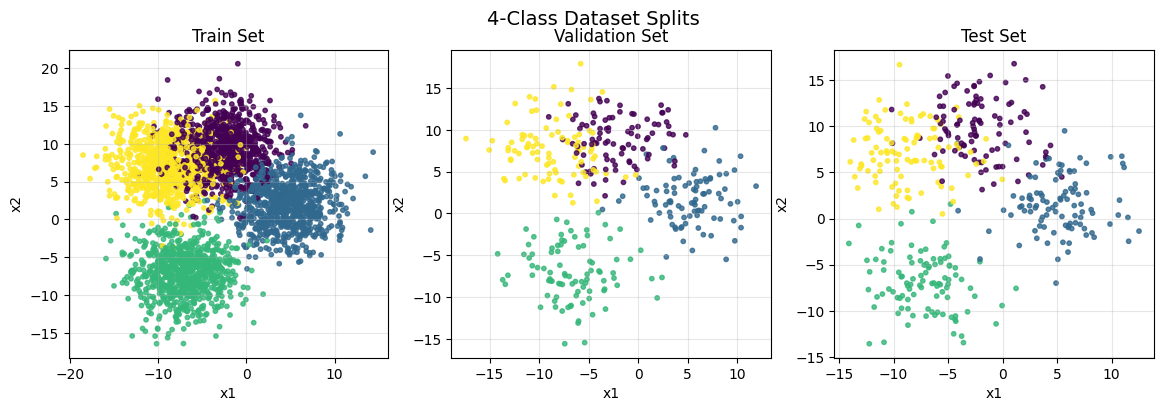

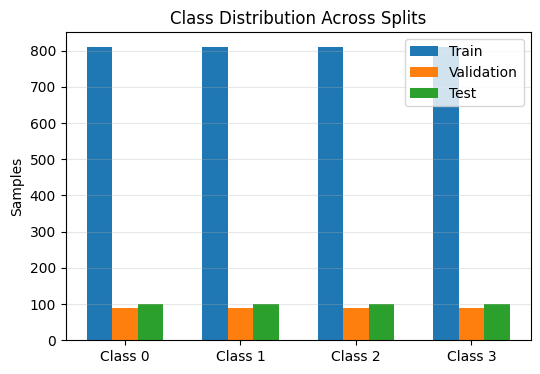

In [4]:
# Define data config and output path
output_path = Path('data', 'blob_dataset')
config = {
    'seed': 42,
    'n_samples': 1000,
    'n_features': 2,
    'n_classes': 4,
    'cluster_std': 3,
    'val_size': 0.1,
    'test_size': 0.1,
}

# Generate synthetic dataset and store it locally
generate_dataset(config, output_path)

In [5]:
# Log artifacts into wandb
log_artifact_wandb(
    files = [
        'data_train.npz', 'data_val.npz', 'data_test.npz',
        'data_split.png', 'data_class_split.png', 'config.yml'
    ],
    files_path = output_path,
    artifact_type = 'dataset',
    description = 'Blob dataset split into train/val/test.'  
)

2025-11-26 12:46:55.513 | SUCCESS  | __main__:log_artifact_wandb:26 - Artifact dataset type successfully uploaded.


## 4. Model training
In this section we will:
1. Use the dataset generated before to
2. Train an MLP to predict the corresponding classes
3. Log model hyperparameters (config) along with performance metrics during training 
4. Save final model checkpoint as another artifact

Take a look at the function below to see how to download artifacts stored in wandb:

In [6]:

def download_artifact_wandb(
    path_to_artifact: str,
    artifact_type: str,
    artifact_version: Optional[str]=None,
    run: Optional[wandb.Run] = None
) -> wandb.Artifact:
    """Download artifact from wandb."""
    # Initialise run if not provided
    if not run:
        run = wandb.init()
        init_run = True
    else:
        init_run = False
    # Specify the version of the dataset, defaults to latest
    artifact_version = 'latest' if artifact_version is None else artifact_version
    # Make full path to the aritifact
    artifact_dir = f'{WANDB_TEAM}/{PROJECT}/{path_to_artifact}:{artifact_version}'
    # Ensure artifact exists
    if artifact_exists(artifact_dir):
        # Point to artifact and retrieve path (download)
        artifact = run.use_artifact(artifact_dir, type=artifact_type)
        artifact_dir = artifact.download()
        logger.success(f'Artifact {path_to_artifact}:{artifact_version} successfully downloaded.')
    else:
        logger.error(f'Artifact {path_to_artifact}:{artifact_version} does not exist.')
    # Finish run if initialised in function
    if init_run:
        run.finish()
    return artifact_dir

def artifact_exists(artifact_ref: str) -> bool:
    """Check if an artifact exists in wandb."""
    api = wandb.Api()
    try:
        _ = api.artifact(artifact_ref)
        return True
    except wandb.errors.CommError:
        # No run active
        return False
    except wandb.errors.ArtifactNotFoundError:
        # No matching artifact
        return False  


The following code shows a full run of a model training and validation. Note the framed sections showing how to:
- connect to wandb
- download dataset artifact generated before
- log train/val metrics on the fly 
- log best performing model as an artifact

In [11]:
def run_model(config=None):
    if config is None:
        config = {
            "seed": 42,
            "epochs": 20,
            "batch_size": 64,
            "lr": 1e-3,
            "input_dim": 2,
            "hidden_dim": 64,
            "output_dim": 4,
            "dropout": 0.1,
            "dataset_artifact": "blob_dataset",
            "device": "cuda",
            "dtype": "float32",
        }

    # Check dtype and device
    config["device"] = get_device()
    logger.debug(config)

    # --------------- W&B initialise run (connect) ----------------
    run = wandb.init(
        project=PROJECT,    # Initialise run in the project
        entity=WANDB_TEAM,  # in the selected team/root
        config=config,      # Automatically save config
    )
    # --------------------------------------------------------------
    # ----- W&B download artifact (retrieves remote path only) -----
    artifact_dir = download_artifact_wandb(
        path_to_artifact = config['dataset_artifact'],
        artifact_type = 'dataset',
        run = run
    )
    # --------------------------------------------------------------

    # Set seed
    set_random_seed(config["seed"])

    # Load and format dataset artifact into DataLoader
    train_loader, val_loader, test_loader = get_dataloaders_from_artifact(
        artifact_dir=artifact_dir, batch_size=config['batch_size'],
        device=config["device"]
    )

    # Define model and optimiser
    model = MLP(
        input_dim=config['input_dim'],
        hidden_dim=config['hidden_dim'],
        output_dim=config['output_dim'],
        dropout=config['dropout']
    ).to(device=config["device"])
    optimizer = torch.optim.Adam(model.parameters(), lr=config['lr'])

    # Initialise variables
    best_val_acc = 0.0
    model_name = "MLP_state_dict.pt"
    model_path = Path("checkpoints")
    model_path.mkdir(exist_ok=True)

    for epoch in tqdm(range(config['epochs'])):
        # Run model through training set across batches (train mode)
        train_loss, train_acc, batch_metrics = run_one_epoch(
            model, train_loader, optimizer, epoch, mode="train"
        )
        # Run model through validation set across batches (eval mode)
        val_loss, val_acc, _ = run_one_epoch(
            model, val_loader, optimizer, epoch, mode="eval"
        )

        # ------- W&B log metrics about training and validation -------
        # Batch metrics come as vectors so need to unwrap them for logging.
        # This step is included here for clarity but would be better implemented
        # in run_one_epoch directly
        if run is not None:
            for v in batch_metrics['loss_batch']:
                run.log({"train/loss_batch": v}) 
        # Overall epoch results for training and validation
        for prefix, loss, acc in (
            ("train", train_loss, train_acc),
            ("val", val_loss, val_acc),
        ):
            if run is not None:
                run.log({
                    f"{prefix}/loss_epoch": loss,
                    f"{prefix}/acc_epoch": acc,
                })
        # --------------------------------------------------------------

        # Track best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), model_path/model_name)
            run.log({"best_val_acc": best_val_acc})

    # ----------------- W&B log model as artifact -----------------
    log_artifact_wandb(
        files = [model_name],
        files_path = model_path,
        artifact_type = 'model',
        description = 'Best baseline model according to validation accuracy',
        run=run
    )
    # --------------------------------------------------------------

    run.finish()

In [8]:

# Run one baseline experiment
model_config = {
    "seed": 42,
    "epochs": 20,
    "batch_size": 64,
    "lr": 1e-3,
    "input_dim": 2,
    "hidden_dim": 64,
    "output_dim": 4,
    "dropout": 0.1,
    "dataset_artifact": "blob_dataset",
    "device": "cuda",
    "dtype": "float32",
}
run_model(model_config)

2025-11-26 12:46:55.791 | DEBUG    | __main__:run_model:19 - {'seed': 42, 'epochs': 20, 'batch_size': 64, 'lr': 0.001, 'input_dim': 2, 'hidden_dim': 64, 'output_dim': 4, 'dropout': 0.1, 'dataset_artifact': 'blob_dataset', 'device': device(type='mps'), 'dtype': 'float32'}


wandb:   6 of 6 files downloaded.  
2025-11-26 12:47:00.499 | SUCCESS  | __main__:download_artifact_wandb:23 - Artifact blob_dataset:latest successfully downloaded.
100%|██████████| 20/20 [00:23<00:00,  1.16s/it]


best_val_acc,▁▃▄▄▆▇█
train/acc_epoch,▁▆▇▇▇▇▇▇█▇█▇████████
train/loss_batch,▅▅█▆▄▃▄▄▄▆▄▃█▄▂▅▅▃▅▂▆▄▂▃▄▄▄▅▇▂▅▄▄▄█▁▃▅▃█
train/loss_epoch,█▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/acc_epoch,▁▃▄▁▄▆▅▇▃▆▅▃▆█▆▇▆██▆
val/loss_epoch,█▅▅▅▄▂▄▂▃▂▃▄▂▂▃▂▃▁▁▃
best_val_acc,0.90556
train/acc_epoch,0.90031
train/loss_batch,0.44931
train/loss_epoch,0.24441
val/acc_epoch,0.88889


2025-11-26 12:47:28.553 | SUCCESS  | __main__:log_artifact_wandb:26 - Artifact model type successfully uploaded.


## 5. Model optimisation

Now we will use W&B Sweeps to explore hyperparameters:
- learning rate (`lr`)
- hidden layer size (`hidden_dim`)
- dropout

Workflow:

1. Define a `sweep_config` (parametes search space and metric to optimise).
2. Define a training function `sweep_train()` that:
   - takes a `default config`
   - overwrites it with hyperparameters from `wandb.config` selected from `sweep_config`
   - trains & logs metrics

In the W&B UI, you will see:
- individual runs
- parallel coordinate plots
- best hyperparameter configurations


In [9]:
sweep_config = {
    "method": "bayes",      # for bayesian optimisation or "grid" for grid-search or "random" for random-search
    "early_terminate": {    # early stopping configuration
        "type": "hyperband",
        "min_iter": 5,
        "max_iter": 50,
        "s": 2,
    },
    "metric": {             # Metric to optimse
        "name": "val/loss_epoch",
        "goal": "minimize"
    },
    "parameters": {         # Parameters to be modified

        "epochs": {
            "value": 20     # Fixed parameter that would be stored with sweep
        },
        "batch_size": {
            "values": [32, 64, 128]
        },
        "lr": {
            "values": [1e-2, 3e-3, 1e-3, 3e-4]
        },
        "hidden_dim": { 
            "values": [32, 64, 128] # Fixed number of possible values
        },
        "dropout": { # Continuous sampling within range
            "min": 0.0,
            "max": 0.3
        },
    }
}


In [ ]:
# Register the config sweep
sweep_id = wandb.sweep(sweep_config, project=PROJECT, entity=WANDB_TEAM)
def sweep_run():
    """Link execution function with generated sampling config"""
    wandb.init(project=PROJECT, entity=WANDB_TEAM)
    # Merge base model config with sweep config
    curr_sweep_config = {**model_config, **wandb.config.as_dict()}
    # Pass config to the run
    run_model(curr_sweep_config)
# Run the registered sweep with the corresponding execution function
wandb.agent(sweep_id, function=sweep_run, count=10)
wandb.finish()    # Finish any active run
wandb._teardown() # Reset wandb internal state (useful in notebooks to avoid updating previous sweeps)

Create sweep with ID: 6ws1r1um
Sweep URL: https://wandb.ai/icl_img_public/wandb_tutorial/sweeps/6ws1r1um


wandb: Agent Starting Run: xj5jlrqe with config:
wandb: 	batch_size: 128
wandb: 	dropout: 0.19116474567979944
wandb: 	epochs: 20
wandb: 	hidden_dim: 32
wandb: 	lr: 0.01


2025-11-26 12:48:40.243 | DEBUG    | __main__:run_model:19 - {'seed': 42, 'epochs': 20, 'batch_size': 128, 'lr': 0.01, 'input_dim': 2, 'hidden_dim': 32, 'output_dim': 4, 'dropout': 0.19116474567979944, 'dataset_artifact': 'blob_dataset', 'device': device(type='mps'), 'dtype': 'float32'}


wandb:   6 of 6 files downloaded.  
2025-11-26 12:48:45.231 | SUCCESS  | __main__:download_artifact_wandb:23 - Artifact blob_dataset:latest successfully downloaded.
100%|██████████| 20/20 [00:13<00:00,  1.44it/s]


best_val_acc,▁▇█
train/acc_epoch,▁▆▇▇▇█▇██▇▇█▇███▇██▇
train/loss_batch,█▂▁▂▁▁▂▁▁▁▁▁▂▂▁▂▂▁▂▂▂▂▁▂▁▁▁▁▁▁▁▂▁▁▂▁▁▁▁▁
train/loss_epoch,█▂▂▂▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁
val/acc_epoch,▄▇▄▁▇▅▅▇▄▃█▆▄▅▅▆▇▆▆▄
val/loss_epoch,▅▂▆▇▁▃▅▂▃█▁▃▃▄▂▂▁▁▂▃
best_val_acc,0.9
train/acc_epoch,0.89167
train/loss_batch,0.29463
train/loss_epoch,0.26528
val/acc_epoch,0.875


2025-11-26 12:49:03.837 | SUCCESS  | __main__:log_artifact_wandb:26 - Artifact model type successfully uploaded.
wandb: Agent Starting Run: l0jwe1mp with config:
wandb: 	batch_size: 32
wandb: 	dropout: 0.21291306660980192
wandb: 	epochs: 20
wandb: 	hidden_dim: 128
wandb: 	lr: 0.0003


2025-11-26 12:49:06.046 | DEBUG    | __main__:run_model:19 - {'seed': 42, 'epochs': 20, 'batch_size': 32, 'lr': 0.0003, 'input_dim': 2, 'hidden_dim': 128, 'output_dim': 4, 'dropout': 0.21291306660980192, 'dataset_artifact': 'blob_dataset', 'device': device(type='mps'), 'dtype': 'float32'}


wandb:   6 of 6 files downloaded.  
2025-11-26 12:49:10.285 | SUCCESS  | __main__:download_artifact_wandb:23 - Artifact blob_dataset:latest successfully downloaded.
100%|██████████| 20/20 [00:42<00:00,  2.12s/it]


best_val_acc,▁▂▄▆▇█
train/acc_epoch,▁▆▆▇▇▇▇▇▇▇▇▇▇███████
train/loss_batch,█▃▅▄▃▆▄▃▂▃▄▁▆▄▃▂▃▄▃▄▆▅▅▂▄▂▆▄▃▃▃▁▄▂▃▃▃▄▃▂
train/loss_epoch,█▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val/acc_epoch,▁▂▄▂▂▄▃▃▃▃▂▆▄▇▇▆▇▆█▇
val/loss_epoch,█▇▆▆▅▇▄▄▅▃▅▄▃▃▁▂▃▃▁▂
best_val_acc,0.89444
train/acc_epoch,0.89414
train/loss_batch,0.20094
train/loss_epoch,0.25846
val/acc_epoch,0.88611


2025-11-26 12:49:56.803 | SUCCESS  | __main__:log_artifact_wandb:26 - Artifact model type successfully uploaded.
wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 10e6n6va with config:
wandb: 	batch_size: 128
wandb: 	dropout: 0.21639132406774175
wandb: 	epochs: 20
wandb: 	hidden_dim: 32
wandb: 	lr: 0.003


2025-11-26 12:50:07.932 | DEBUG    | __main__:run_model:19 - {'seed': 42, 'epochs': 20, 'batch_size': 128, 'lr': 0.003, 'input_dim': 2, 'hidden_dim': 32, 'output_dim': 4, 'dropout': 0.21639132406774175, 'dataset_artifact': 'blob_dataset', 'device': device(type='mps'), 'dtype': 'float32'}


wandb:   6 of 6 files downloaded.  
2025-11-26 12:50:12.808 | SUCCESS  | __main__:download_artifact_wandb:23 - Artifact blob_dataset:latest successfully downloaded.
100%|██████████| 20/20 [00:14<00:00,  1.39it/s]


best_val_acc,▁▅▇▇█
train/acc_epoch,▁▇▇▇████████████████
train/loss_batch,█▄▂▂▂▂▁▂▁▂▂▂▁▁▂▂▂▁▂▂▁▂▁▁▁▁▁▁▂▂▁▁▂▁▁▁▁▁▁▂
train/loss_epoch,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/acc_epoch,▁▅▁▅▇▄▅▇▂▅▇▆▅▃▆▄▅▇▅█
val/loss_epoch,█▄▅▃▃▄▄▂▂▂▂▂▂▄▁▃▂▁▂▁
best_val_acc,0.89722
train/acc_epoch,0.89444
train/loss_batch,0.29105
train/loss_epoch,0.26307
val/acc_epoch,0.89722


2025-11-26 12:50:31.105 | SUCCESS  | __main__:log_artifact_wandb:26 - Artifact model type successfully uploaded.
wandb: Agent Starting Run: 37n8aeln with config:
wandb: 	batch_size: 128
wandb: 	dropout: 0.036775822549099745
wandb: 	epochs: 20
wandb: 	hidden_dim: 64
wandb: 	lr: 0.01


2025-11-26 12:50:34.415 | DEBUG    | __main__:run_model:19 - {'seed': 42, 'epochs': 20, 'batch_size': 128, 'lr': 0.01, 'input_dim': 2, 'hidden_dim': 64, 'output_dim': 4, 'dropout': 0.036775822549099745, 'dataset_artifact': 'blob_dataset', 'device': device(type='mps'), 'dtype': 'float32'}


wandb:   6 of 6 files downloaded.  
2025-11-26 12:50:38.758 | SUCCESS  | __main__:download_artifact_wandb:23 - Artifact blob_dataset:latest successfully downloaded.
100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


best_val_acc,▁▃▆▇██
train/acc_epoch,▁▆▆▇▆▇▇▇▇▇▇▇▇█▇▇▇▇██
train/loss_batch,█▇▆▄▆▃▃▃▅▅▃▅▇▂▇▃▁▄▂▇▅▂▇▆▆▄▄█▄▃▆▃▅▅▂▅▄▅▅▁
train/loss_epoch,█▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val/acc_epoch,▁▃▆▅▄▇▆▇▆█▅▇▅▅██▅▇▇▆
val/loss_epoch,█▄▄▄▅▃▂▂▇▁▄▃▆▆▂▁▇▂▂▃
best_val_acc,0.90278
train/acc_epoch,0.90123
train/loss_batch,0.16581
train/loss_epoch,0.2475
val/acc_epoch,0.88889


2025-11-26 12:50:56.299 | SUCCESS  | __main__:log_artifact_wandb:26 - Artifact model type successfully uploaded.
wandb: Agent Starting Run: 71wpbxel with config:
wandb: 	batch_size: 128
wandb: 	dropout: 0.058821538141508145
wandb: 	epochs: 20
wandb: 	hidden_dim: 128
wandb: 	lr: 0.01


2025-11-26 12:51:00.688 | DEBUG    | __main__:run_model:19 - {'seed': 42, 'epochs': 20, 'batch_size': 128, 'lr': 0.01, 'input_dim': 2, 'hidden_dim': 128, 'output_dim': 4, 'dropout': 0.058821538141508145, 'dataset_artifact': 'blob_dataset', 'device': device(type='mps'), 'dtype': 'float32'}


wandb:   6 of 6 files downloaded.  
2025-11-26 12:51:05.217 | SUCCESS  | __main__:download_artifact_wandb:23 - Artifact blob_dataset:latest successfully downloaded.
100%|██████████| 20/20 [00:13<00:00,  1.45it/s]


best_val_acc,▁█
train/acc_epoch,▁▅▇▇▇██▇▇▇▇▇▇███████
train/loss_batch,█▂▁▂▃▁▂▁▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▁▁▂▁▁▂
train/loss_epoch,█▄▃▂▂▁▁▁▁▂▂▂▂▁▁▁▁▂▁▁
val/acc_epoch,▇▅▅▃█▇█▅▁▇▅▄▆▇█▅▅▇▇▆
val/loss_epoch,▃▃▂▅▁▁▁▂█▂▂▃▁▁▂▂▃▂▂▂
best_val_acc,0.9
train/acc_epoch,0.90062
train/loss_batch,0.20655
train/loss_epoch,0.25042
val/acc_epoch,0.88611


2025-11-26 12:51:23.154 | SUCCESS  | __main__:log_artifact_wandb:26 - Artifact model type successfully uploaded.
wandb: Agent Starting Run: 1zsi6u84 with config:
wandb: 	batch_size: 128
wandb: 	dropout: 0.02596708939766722
wandb: 	epochs: 20
wandb: 	hidden_dim: 128
wandb: 	lr: 0.01


2025-11-26 12:51:26.805 | DEBUG    | __main__:run_model:19 - {'seed': 42, 'epochs': 20, 'batch_size': 128, 'lr': 0.01, 'input_dim': 2, 'hidden_dim': 128, 'output_dim': 4, 'dropout': 0.02596708939766722, 'dataset_artifact': 'blob_dataset', 'device': device(type='mps'), 'dtype': 'float32'}


wandb:   6 of 6 files downloaded.  
2025-11-26 12:51:31.302 | SUCCESS  | __main__:download_artifact_wandb:23 - Artifact blob_dataset:latest successfully downloaded.
100%|██████████| 20/20 [00:12<00:00,  1.56it/s]


best_val_acc,▁▄▅▇█
train/acc_epoch,▁▅▇▇▇█▇██▇▇▇▇███████
train/loss_batch,█▂▂▂▃▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▁▁▁▁▂▂▁▁▁▁▂▂▁
train/loss_epoch,█▅▃▂▂▁▁▁▁▂▂▂▂▁▁▁▁▁▁▂
val/acc_epoch,▄▅▆▃█▅█▆▁▆▅▃▆▆▆▅▆▆▇▆
val/loss_epoch,▃▃▂▅▁▂▁▁█▂▃▆▂▂▂▂▂▂▁▂
best_val_acc,0.90556
train/acc_epoch,0.89907
train/loss_batch,0.19902
train/loss_epoch,0.25077
val/acc_epoch,0.88889


2025-11-26 12:51:48.272 | SUCCESS  | __main__:log_artifact_wandb:26 - Artifact model type successfully uploaded.
wandb: Agent Starting Run: f6fn65gy with config:
wandb: 	batch_size: 128
wandb: 	dropout: 0.01298238702586757
wandb: 	epochs: 20
wandb: 	hidden_dim: 64
wandb: 	lr: 0.003


2025-11-26 12:51:53.562 | DEBUG    | __main__:run_model:19 - {'seed': 42, 'epochs': 20, 'batch_size': 128, 'lr': 0.003, 'input_dim': 2, 'hidden_dim': 64, 'output_dim': 4, 'dropout': 0.01298238702586757, 'dataset_artifact': 'blob_dataset', 'device': device(type='mps'), 'dtype': 'float32'}


wandb:   6 of 6 files downloaded.  
2025-11-26 12:51:58.424 | SUCCESS  | __main__:download_artifact_wandb:23 - Artifact blob_dataset:latest successfully downloaded.
100%|██████████| 20/20 [00:14<00:00,  1.43it/s]


best_val_acc,▁▃▄▆▇▇█
train/acc_epoch,▁▇▇▇▇██▇████▇█▇████▇
train/loss_batch,▇█▄▃▆▄▄▃▃▅▁▄▂▄▆▆▆▆▆▂▄▂▄▅▂▇▁▃▃▂▆▁▂▄▅▃▅▅▁▁
train/loss_epoch,█▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/acc_epoch,▂▄▄▆▆▇▅▇▇▇▇▁▅▆▄▆▄██▆
val/loss_epoch,█▃▄▃▃▂▂▁▃▁▂▄▃▃▃▁▂▁▂▂
best_val_acc,0.9
train/acc_epoch,0.89259
train/loss_batch,0.18319
train/loss_epoch,0.24589
val/acc_epoch,0.89167


2025-11-26 12:52:16.554 | SUCCESS  | __main__:log_artifact_wandb:26 - Artifact model type successfully uploaded.
wandb: Agent Starting Run: ia439to2 with config:
wandb: 	batch_size: 128
wandb: 	dropout: 0.016403833843443738
wandb: 	epochs: 20
wandb: 	hidden_dim: 128
wandb: 	lr: 0.003


2025-11-26 12:52:20.086 | DEBUG    | __main__:run_model:19 - {'seed': 42, 'epochs': 20, 'batch_size': 128, 'lr': 0.003, 'input_dim': 2, 'hidden_dim': 128, 'output_dim': 4, 'dropout': 0.016403833843443738, 'dataset_artifact': 'blob_dataset', 'device': device(type='mps'), 'dtype': 'float32'}


wandb:   6 of 6 files downloaded.  
2025-11-26 12:52:24.777 | SUCCESS  | __main__:download_artifact_wandb:23 - Artifact blob_dataset:latest successfully downloaded.
100%|██████████| 20/20 [00:12<00:00,  1.64it/s]


best_val_acc,▁▃█
train/acc_epoch,▁▅▆▆▇███▇▇▇▇▇███████
train/loss_batch,█▂▂▂▂▁▂▁▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▂▂▂▁▂▁▂▁▁
train/loss_epoch,█▃▂▂▂▂▂▁▁▂▂▂▂▁▁▁▂▁▁▁
val/acc_epoch,▄▅▅▃█▅▇▇▁▅▇▃▇▇▆▆▆▇▇▆
val/loss_epoch,▆▄▃▅▁▂▁▃█▅▃▆▁▁▂▂▂▂▃▂
best_val_acc,0.9
train/acc_epoch,0.90154
train/loss_batch,0.1797
train/loss_epoch,0.2432
val/acc_epoch,0.89167


2025-11-26 12:52:41.065 | SUCCESS  | __main__:log_artifact_wandb:26 - Artifact model type successfully uploaded.
wandb: Agent Starting Run: k8cdvz8k with config:
wandb: 	batch_size: 128
wandb: 	dropout: 0.011758155969146488
wandb: 	epochs: 20
wandb: 	hidden_dim: 128
wandb: 	lr: 0.003


2025-11-26 12:52:46.472 | DEBUG    | __main__:run_model:19 - {'seed': 42, 'epochs': 20, 'batch_size': 128, 'lr': 0.003, 'input_dim': 2, 'hidden_dim': 128, 'output_dim': 4, 'dropout': 0.011758155969146488, 'dataset_artifact': 'blob_dataset', 'device': device(type='mps'), 'dtype': 'float32'}


wandb:   6 of 6 files downloaded.  
2025-11-26 12:52:50.980 | SUCCESS  | __main__:download_artifact_wandb:23 - Artifact blob_dataset:latest successfully downloaded.
100%|██████████| 20/20 [00:12<00:00,  1.58it/s]


best_val_acc,▁▅▆█
train/acc_epoch,▁▅▆▆▇█▇██▇▇▇▇███████
train/loss_batch,█▂▂▂▂▂▁▁▁▁▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▂▂▂▁▁▂▁▂▁
train/loss_epoch,█▃▂▂▂▁▂▁▁▂▂▂▂▁▁▁▁▁▁▁
val/acc_epoch,▄▆▅▄▇▇█▅▁▆▄▂██▆▇▆▆▇▇
val/loss_epoch,▅▄▃▄▁▂▁▃▇▆▄█▁▁▂▂▂▂▂▂
best_val_acc,0.89722
train/acc_epoch,0.89969
train/loss_batch,0.18274
train/loss_epoch,0.24351
val/acc_epoch,0.89167


2025-11-26 12:53:07.781 | SUCCESS  | __main__:log_artifact_wandb:26 - Artifact model type successfully uploaded.
wandb: Agent Starting Run: 0nh9lm3x with config:
wandb: 	batch_size: 128
wandb: 	dropout: 0.00269098437833295
wandb: 	epochs: 20
wandb: 	hidden_dim: 128
wandb: 	lr: 0.001


2025-11-26 12:53:12.815 | DEBUG    | __main__:run_model:19 - {'seed': 42, 'epochs': 20, 'batch_size': 128, 'lr': 0.001, 'input_dim': 2, 'hidden_dim': 128, 'output_dim': 4, 'dropout': 0.00269098437833295, 'dataset_artifact': 'blob_dataset', 'device': device(type='mps'), 'dtype': 'float32'}


wandb:   6 of 6 files downloaded.  
2025-11-26 12:53:17.194 | SUCCESS  | __main__:download_artifact_wandb:23 - Artifact blob_dataset:latest successfully downloaded.
100%|██████████| 20/20 [00:12<00:00,  1.56it/s]


best_val_acc,▁▅▇█
train/acc_epoch,▁▆▆▇▇▇▇█████████████
train/loss_batch,█▂▂▂▂▁▂▁▁▂▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▂▂▁▁▁▁▂▁
train/loss_epoch,█▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/acc_epoch,▃▁▆▃▅▄▇▆▄██▇▆▇▆█▅▆▇▇
val/loss_epoch,██▄▆▃▅▃▃▆▃▂▂▁▂▂▁▂▁▂▂
best_val_acc,0.9
train/acc_epoch,0.90123
train/loss_batch,0.17147
train/loss_epoch,0.2389
val/acc_epoch,0.89167


2025-11-26 12:53:34.442 | SUCCESS  | __main__:log_artifact_wandb:26 - Artifact model type successfully uploaded.


## 6. Model evaluation
Now we can inspec the models' performance in [wandb interactive dashboard](https://wandb.ai/icl_img/wandb_tutorial/).

We can also query this programatically to retrieve a specific model:

In [16]:
# Connect to wandb
api = wandb.Api({'entity':WANDB_TEAM})
runs = api.runs(PROJECT)
# Select runs that contain metric of interest
valid_runs = [r for r in runs if "val/loss_epoch" in r.summary]
if not valid_runs:
    raise ValueError("No runs contain 'val/loss_epoch' in summary.")

# Apply metric criterion (in this case min(val/loss_epoch))
best = min(valid_runs, key=lambda r: r.summary["val/loss_epoch"])
logger.info(f"Best run: {best}")

# Retrieve remote path to artifact
best_artifact = best.logged_artifacts()[0]
artifact_dir = best_artifact.download()

# Get config used to initialise and train the model artifact
art_config = best_artifact.logged_by().config

# Get file with the state_dict (in this case select by .pt extension)
art_state_dict = [p for p in Path(artifact_dir).iterdir() if p.suffix == ".pt"][0]
logger.info(f"Best model: {art_state_dict}")
logger.info(f"Best model config: {art_config}")
wandb.finish()

2025-11-26 12:54:39.977 | INFO     | __main__:<module>:11 - Best run: <Run icl_img_public/wandb_tutorial/0nh9lm3x (finished)>
wandb:   1 of 1 files downloaded.  
2025-11-26 12:54:42.397 | INFO     | __main__:<module>:22 - Best model: /Users/irene/Documents/Work_local/wandb_tutorial/artifacts/checkpoints:v34/MLP_state_dict.pt
2025-11-26 12:54:42.398 | INFO     | __main__:<module>:23 - Best model config: {'lr': 0.001, 'seed': 42, 'dtype': 'float32', 'device': 'mps', 'epochs': 20, 'dropout': 0.00269098437833295, 'input_dim': 2, 'batch_size': 128, 'hidden_dim': 128, 'output_dim': 4, 'dataset_artifact': 'blob_dataset'}


Now we can run that model on the test set, the held-out data not used for model selection.

In [19]:
# W&B initialise run (connect)
run = wandb.init(
    project=PROJECT,        # Initialise run in the project
    entity=WANDB_TEAM,      # in the selected team/root
    config=art_config,      # Automatically save config
    reinit='create_new'     # Forces initalisation of a new run
)

# Set seed
set_random_seed(art_config["seed"])

# Download artifact from W&B and senf it to DataLoader
artifact_dir = download_artifact_wandb(
    path_to_artifact = art_config['dataset_artifact'],
    artifact_type = 'dataset',
    run = run
)

# Load and format dataset artifact into DataLoader
train_loader, val_loader, test_loader = get_dataloaders_from_artifact(
    artifact_dir=artifact_dir, batch_size=art_config['batch_size'],
    device=art_config["device"]
)

# ----- Initialise model from W&B artifact and config (after query) -----
model = MLP(
    input_dim = art_config['input_dim'],
    hidden_dim = art_config['hidden_dim'],
    output_dim = art_config['output_dim'],
    dropout = art_config['dropout'],
).to(art_config['device'])
state_dict = torch.load(art_state_dict)
model.load_state_dict(state_dict)
logger.success(f'Model loaded from {art_state_dict}')
# ------------------------------------------------------------------------

optimizer = torch.optim.Adam(model.parameters(), lr=art_config['lr'])

for epoch in tqdm(range(art_config['epochs'])):
    # Run model through test set across batches (eval mode)
    test_loss, test_acc, _ = run_one_epoch(
        model, test_loader, optimizer, epoch, mode="eval"
    )

    # W&B log metrics about training and validation
    if run is not None:
        run.log({
            "test/loss_epoch": test_loss,
            "test/acc_epoch": test_acc,
        })

run.finish()

wandb:   6 of 6 files downloaded.  
2025-11-26 12:56:53.453 | SUCCESS  | __main__:download_artifact_wandb:23 - Artifact blob_dataset:latest successfully downloaded.
2025-11-26 12:56:54.403 | SUCCESS  | __main__:<module>:34 - Model loaded from /Users/irene/Documents/Work_local/wandb_tutorial/artifacts/checkpoints:v34/MLP_state_dict.pt
100%|██████████| 20/20 [00:01<00:00, 16.90it/s]


test/acc_epoch,▅▃▆▅▅▅▁▆▅▆▆▆▅▆▃█▆▅▃▆
test/loss_epoch,▆▄▅▇▇█▅█▆▅▄▂▇▆▅▄▁▇▄▇
test/acc_epoch,0.915
test/loss_epoch,0.26237


Finally we can make results sharable a [W&B report](https://api.wandb.ai/links/icl_img_public/zzkwrgwy)